In [10]:
%%time
# Ignore this block -- it's for the documentation build
try:
    import os, sys
    sys.path.insert(1, os.path.abspath('/home/runner/work/psi4/psi4/code/objdir/stage//usr/local/psi4/lib/'))
except ImportError:
    pass

# This is the important part
import psi4

CPU times: user 20 µs, sys: 3 µs, total: 23 µs
Wall time: 26.9 µs


In [11]:
%%time
psi4.set_output_file('output.dat', False)

CPU times: user 299 µs, sys: 1.05 ms, total: 1.35 ms
Wall time: 3.75 ms


PosixPath('output.dat')

In [12]:
%%time
#! Sample HF/cc-pVDZ H2O Computation

psi4.set_memory('500 MB')

h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

psi4.energy('scf/cc-pvdz')

CPU times: user 316 ms, sys: 12.9 ms, total: 329 ms
Wall time: 344 ms


-76.02663273509017

In [13]:
%%time
#! Sample UHF/6-31G** CH2 Computation

R = 1.075
A = 133.93

ch2 = psi4.geometry("""
0 3
C
H 1 {0}
H 1 {0} 2 {1}
""".format(R, A)
)

psi4.set_options({'reference': 'uhf'})
psi4.energy('scf/6-31g**')

CPU times: user 309 ms, sys: 8.91 ms, total: 318 ms
Wall time: 322 ms


-38.925334628937065

In [14]:
%%time
psi4.set_options({'reference': 'rhf'})
psi4.optimize('scf/cc-pvdz', molecule=h2o)

Optimizer: Optimization complete!
CPU times: user 893 ms, sys: 27.3 ms, total: 921 ms
Wall time: 933 ms


-76.0270327293733

In [15]:
%%time
scf_e, scf_wfn = psi4.frequency('scf/cc-pvdz', molecule=h2o, return_wfn=True)

CPU times: user 1.05 s, sys: 15.9 ms, total: 1.07 s
Wall time: 1.08 s


In [16]:
%%time
# Example SAPT computation for ethene*ethyne (*i.e.*, ethylene*acetylene).
# Test case 16 from S22 Database

dimer = psi4.geometry("""
0 1
C   0.000000  -0.667578  -2.124659
C   0.000000   0.667578  -2.124659
H   0.923621  -1.232253  -2.126185
H  -0.923621  -1.232253  -2.126185
H  -0.923621   1.232253  -2.126185
H   0.923621   1.232253  -2.126185
--
0 1
C   0.000000   0.000000   2.900503
C   0.000000   0.000000   1.693240
H   0.000000   0.000000   0.627352
H   0.000000   0.000000   3.963929
units angstrom
""")

CPU times: user 1.17 ms, sys: 27 µs, total: 1.2 ms
Wall time: 1.21 ms


In [17]:
%%time
psi4.set_options({'scf_type': 'df',
                  'freeze_core': True})

psi4.energy('sapt0/jun-cc-pvdz', molecule=dimer)

CPU times: user 4.13 s, sys: 295 ms, total: 4.42 s
Wall time: 4.5 s


-0.0022355823909805178

In [19]:
%%time
#! Example potential energy surface scan and CP-correction for Ne2

ne2_geometry = """
Ne
--
Ne 1 {0}
"""

Rvals = [2.5, 3.0, 4.0]

psi4.set_options({'freeze_core': True})

# Initialize a blank dictionary of counterpoise corrected energies
# (Need this for the syntax below to work)

ecp = {}

for R in Rvals:
    ne2 = psi4.geometry(ne2_geometry.format(R))
    ecp[R] = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=ne2)

# Prints to screen
print("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    print("            {:3.1f}                        {:1.6f}".format(R, e))

# Prints to output.dat
psi4.core.print_out("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
psi4.core.print_out("          R [Ang]                 E_int [kcal/mol]       \n")
psi4.core.print_out("---------------------------------------------------------\n")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    psi4.core.print_out("            {:3.1f}                        {:1.6f}\n".format(R, e))

CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies


          R [Ang]                 E_int [kcal/mol]       
---------------------------------------------------------
            2.5                        0.758605
            3.0                        0.015968
            4.0                        -0.016215
CPU times: user 5.65 s, sys: 1.57 s, total: 7.22 s
Wall time: 7.64 s


In [21]:
import numpy as np

def lj(r, sigma, eps):
    return 4 * eps * ((sigma/r)**12 - (sigma/r)**6)

distances = np.linspace(3.5, 6.0, num=20)
energies = []

psi4.set_options({'freeze_core': True})
for d in distances:
    mol = psi4.geometry(f"""
    Ar
    --
    Ar 1 {d}
    """)

    # psi4.optimize('B3LYP', molecule=mol)
    energy = psi4.energy("ccsd(t)/aug-cc-pvdz", bsse_type='cp', molecule=mol)
    energies.append(energy)

In [24]:
from scipy.optimize import curve_fit

# Define the Lennard-Jones potential function
def lj(r, sigma, eps):
    return 4 * eps * ((sigma / r)**12 - (sigma / r)**6)

# Assuming initial_guess represents the initial values for sigma and eps
initial_guess = [3.5, 0.1]

# Perform curve fitting to the Lennard-Jones potential
params, params_covariance = curve_fit(lj, distances, energies, p0=initial_guess)

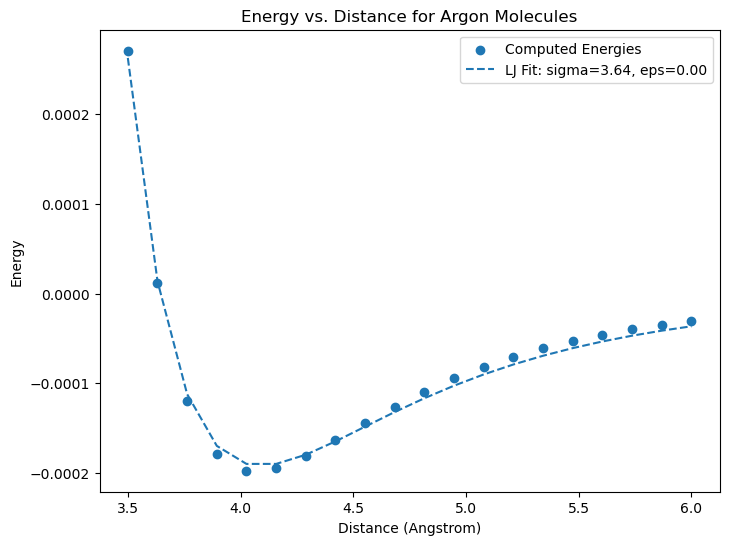

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(distances, energies, label='Computed Energies')
plt.plot(distances, lj(distances, *params), linestyle='dashed', label='LJ Fit: sigma=%.2f, eps=%.2f' % tuple(params))
plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.title('Energy vs. Distance for Argon Molecules')

plt.savefig('Figures/argon_energy_curve.png')
plt.show()